# Task 3 - Convolutional Neural Network

In [93]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
#
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cpu')

## Data set

Import data set:

from sklearn.datasets import make_blobs

samples = 5000
#Let's divide the toy dataset into training (80%) and rest for validation.
train_split = int(samples*0.8)
#Create a dummy classification dataset
X, y = make_blobs(n_samples=samples, centers=2, n_features=64, cluster_std=10, random_state=2020)

y = y.reshape(-1,1) # Expanding dimension of y

#Convert the numpy datasets to Torch Tensors
X,y = torch.from_numpy(X),torch.from_numpy(y)

X,y =X.float(),y.float()
#Split the datasets inot train and test(validation)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

*Source*: https://www.kaggle.com/datasets/zalando-research/fashionmnist

(60000,)

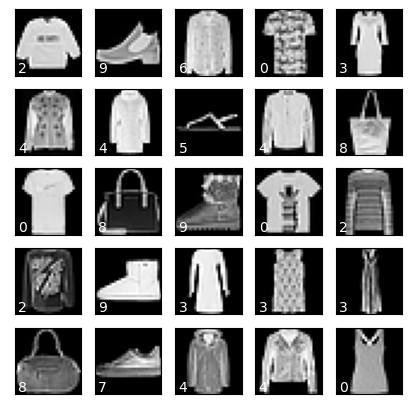

In [96]:
# Import the data sets
path = "../data/fashon_MNIST/"
train = pd.read_csv(path+"fashion-mnist_train.csv")
test = pd.read_csv(path+"fashion-mnist_test.csv")

y_train = train["label"].values
y_test = test["label"].values

X_train = (train.iloc[:,1:].values).astype('float32')
X_test = (test.iloc[:,1:].values).astype('float32')

# Display some images
fig, axes = plt.subplots(5,5, figsize=(5, 5),subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax.text(0.05, 0.05, str(y_train[i]),  # type: ignore
            transform=ax.transAxes, color='white')
    
# Reshape and normalise the data
X_train = X_train.reshape(X_train.shape[0],1, 28, 28) / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28) / 255

Preprocess data for PyTorch:

In [97]:
# Create tensor
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#y_train_tensor = F.one_hot(y_train_tensor, num_classes=10)
#y_test_tensor = F.one_hot(y_test_tensor, num_classes=10)

# Create TensorDatasets
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_tensor, batch_size=8000, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=8000, shuffle=True)

## Neural network

In [98]:
class NN1(nn.Module):
    
    def __init__(self, num_classes=10):
        super(NN1, self).__init__()
        #First unit of convolution
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Second unit of convolution
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Fully connected layers
        self.fc1 = nn.Linear(7*7*32, 128)
        self.fc2 = nn.Linear(128, 10)
    #Connect the units
    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out


In [99]:
class NeuralNetwork():
    
    def __init__(self, nn):
        self.nn = nn
    
    def initialise(self, loss_function, optimizer):
    
        self.loss_function = loss_function
        self.optimizer = optimizer
        
    def fit(self, data_loader, max_epochs):
        
        L_history = []
                       
        for epoch in range(max_epochs):
            
            L_batch = 0.0
            
            for data, target in data_loader:
                
                data = data.to(device)
                target = target.to(device)
            
                # Set gradients to zero
                self.optimizer.zero_grad()
    
                # Forward pass
                output = self.nn(data)
    
                # Compute loss 
                L = self.loss_function(output, target)
    
                # Backward pass
                L.backward()
        
                # Weights update
                self.optimizer.step()
                
                L_batch += L.item() * data.size(0)
                
    
            L_history.append(L_batch/len(data_loader.sampler))
        

        self.L_history = L_history
        
    def predict(self, data_loader):
        
        self.nn.eval()
        
        y_pred = torch.LongTensor()   
        y_test = torch.LongTensor()
        
        for data, target in data_loader:
            
            batch_output = self.nn(data)
            
            # Take the index with highest probability
            batch_preds = batch_output.data.max(1,keepdim=True)[1]
            
            #Combine tensors from each batch
            y_pred = torch.cat((y_pred, batch_preds), dim=0)
            
            y_test = torch.cat((y_test, target), dim=0)
            
            return y_pred, y_test
        
        #print("Accuracy: %.2f" % test)
        #print("\n")
        
        #fig, ax = plt.subplots(figsize = (5,5))
        #ax.plot(self.L_history)
        #ax.set_xlabel("Epochs")
        #ax.set_ylabel("Loss")
    

## Solution

Define different structures for the neural network:

In [100]:
# first neural network
NN1 = NN1().to(device)

Solve the neural network:

In [101]:
NN = NeuralNetwork(NN1)
NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(NN1.parameters(),lr= 0.001) )
NN.fit(train_loader, max_epochs = 5)
#NN.evaluate(X_test, y_test)

In [102]:
y_pred, y_test = NN.predict(test_loader)
print("Accuracy: %.2f"%accuracy_score(y_pred, y_test))

Accuracy: 0.82


## CNN layers

**Filters**:
- Number of filters K (2,4, order of 2)
- Filter size F (odd mostly, 3, 5 )
- Stride S (mostly one)
- Padding amount P

**Pooling**:
- F = 2, 3
- S = 1 , 2

class NeuralNetwork_OLD():
    
    def __init__(self, nn):
        self.nn = nn
    
    def initialise(self, loss_function, optimizer):
    
        self.loss_function = loss_function
        self.optimizer = optimizer
        
    def fit(self, X, y, max_epochs, n_mini_batches):
        
        L_history = []
                
        # Create batches of mini-batch training
        batch_size = int(len(X)/n_mini_batches) # batch dimension
        batches = [range(x,min(x+batch_size,len(X))) for x in range(0, len(X), batch_size)]
        
        for epoch in range(max_epochs):
            
            # Shuffle data
            shuffle_indices = np.arange(len(X))
            np.random.shuffle(shuffle_indices)
            X = X[shuffle_indices]
            y = y[shuffle_indices] 
            
            L_batch = 0.0 
            
            for batch in batches: # Train each batch independently 
                
                # Select batches
                X_batch = X[batch]
                y_batch = y[batch]

                # Set gradients to zero
                self.optimizer.zero_grad()
    
                # Forward pass
                output = self.nn(X_batch)
    
                # Compute loss 
                L = self.loss_function(output, y_batch)
    
                # Backward pass
                L.backward()
        
                # Weights update
                self.optimizer.step()
                
                L_batch += L.item() * batch_size
    
            L_history.extend([L_batch])

        self.L_history = L_history
        
    def evaluate(self, X, y):
        
        
        y_pred = self.nn(X)
        a =np.where(y_pred>0.5,1,0)
        test = sum(a == y.numpy())/len(y)
        
        print("Accuracy: %.2f" % test)
        print("\n")
        
        fig, ax = plt.subplots(figsize = (5,5))
        ax.plot(self.L_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
    